In [2]:
# %%
#%matplotlib inline
import os

from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2 import model_zoo
from detectron2.config import get_cfg

/home/appuser/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# %%
dataset_train_name = "lego-classification_train"
# %%
register_coco_instances(dataset_train_name, {}, "./data/train.json", "./data/images")

# %%
lego_classificiation_train_metadata = MetadataCatalog.get(dataset_train_name)

DatasetCatalog.get(dataset_train_name)


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



[{'file_name': './data/images/9175fad8-db64-11eb-a416-3497f683a169.jpg',
  'height': 600,
  'width': 600,
  'image_id': 1,
  'annotations': [{'bbox': [157.99999237060547,
     0.0,
     32.999999821186066,
     34.00000110268593],
    'category_id': 115,
    'bbox_mode': <BoxMode.XYWH_ABS: 1>},
   {'bbox': [467.9999828338623,
     218.00000667572021,
     54.00000214576721,
     154.99999523162842],
    'category_id': 356,
    'bbox_mode': <BoxMode.XYWH_ABS: 1>},
   {'bbox': [141.99999868869781,
     59.00000184774399,
     74.00000095367432,
     162.00000643730164],
    'category_id': 57,
    'bbox_mode': <BoxMode.XYWH_ABS: 1>},
   {'bbox': [80.00000417232513,
     526.9999980926514,
     70.99999934434891,
     73.00000190734863],
    'category_id': 415,
    'bbox_mode': <BoxMode.XYWH_ABS: 1>}]},
 {'file_name': './data/images/8dc41352-da5e-11eb-9995-3497f683a169.jpg',
  'height': 600,
  'width': 600,
  'image_id': 2,
  'annotations': [{'bbox': [522.000002861023,
     174.99999403953

In [4]:
# %%
dataset_val_name = "lego-classification_valid"
# %%
register_coco_instances(dataset_val_name, {}, "./data/valid.json", "./data/images")

# %%
MetadataCatalog.get(dataset_val_name)
dataset_dicts = DatasetCatalog.get(dataset_val_name)


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



In [5]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml"))
cfg.DATASETS.TRAIN = (dataset_train_name, dataset_val_name)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(lego_classificiation_train_metadata.thing_classes)  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
cfg.INPUT.MIN_SIZE_TRAIN = (300, 300, 300)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.


In [6]:
# %%
from detectron2.engine import DefaultTrainer
import torch
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[03/15 10:48:33 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 2048) in the checkpoint but (575, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (575,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 2048) in the checkpoint but (2296, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (2296,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score

[03/15 10:48:43 d2.engine.train_loop]: Starting training from iteration 0


/home/appuser/.local/lib/python3.6/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[03/15 10:48:52 d2.utils.events]:  eta: 0:07:10  iter: 19  total_loss: 6.674  loss_cls: 6.336  loss_box_reg: 0.2725  loss_rpn_cls: 0.04389  loss_rpn_loc: 0.009188  time: 0.4416  data_time: 0.0098  lr: 4.9953e-06  max_mem: 4063M
[03/15 10:49:01 d2.utils.events]:  eta: 0:07:03  iter: 39  total_loss: 6.411  loss_cls: 6.143  loss_box_reg: 0.2321  loss_rpn_cls: 0.04338  loss_rpn_loc: 0.007716  time: 0.4436  data_time: 0.0027  lr: 9.9902e-06  max_mem: 4063M
[03/15 10:49:10 d2.utils.events]:  eta: 0:06:55  iter: 59  total_loss: 5.917  loss_cls: 5.618  loss_box_reg: 0.2588  loss_rpn_cls: 0.02304  loss_rpn_loc: 0.007661  time: 0.4441  data_time: 0.0028  lr: 1.4985e-05  max_mem: 4063M
[03/15 10:49:19 d2.utils.events]:  eta: 0:06:46  iter: 79  total_loss: 4.761  loss_cls: 4.417  loss_box_reg: 0.267  loss_rpn_cls: 0.02948  loss_rpn_loc: 0.008942  time: 0.4440  data_time: 0.0028  lr: 1.998e-05  max_mem: 4063M
[03/15 10:49:28 d2.utils.events]:  eta: 0:06:38  iter: 99  total_loss: 1.834  loss_cls: 1.

In [7]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

Reusing TensorBoard on port 6006 (pid 11947), started 19:54:45 ago. (Use '!kill 11947' to kill it.)

In [8]:
from detectron2.engine import DefaultPredictor
cfg = get_cfg()
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
cfg.INPUT.MIN_SIZE_TRAIN = (300, 300, 300)
predictor = DefaultPredictor(cfg)

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (575, 2048) in the checkpoint but (81, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (575,) in the checkpoint but (81,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (2296, 2048) in the checkpoint but (320, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (2296,) in the checkpoint but (320,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score

In [9]:
import random
import cv2


d = random.sample(dataset_dicts, 1)[0]

In [10]:
from detectron2.utils.visualizer import Visualizer, ColorMode
img = cv2.imread(d['file_name'])
outputs = predictor(img)
visualizer = Visualizer(img[:, :, ::-1], metadata=lego_classificiation_train_metadata, scale=0.5, instance_mode=ColorMode.IMAGE_BW)
v = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))

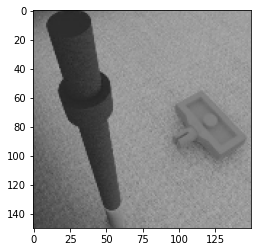

In [11]:
import matplotlib.pyplot as plt
plt.imshow(v.get_image()[:, :, ::-1])